# English Premier League sports-betting model

The purpose of this notebook is to present the exploratory data analysis that was conducted before the modeling process.

In [5]:
# import relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# reading in the data
df = pd.read_excel('/Users/schoollaptop/Documents/FLATIRON2021/CAPSTONE/results.xlsm')
df.head()

,Season,DateTime,HomeTeam,AwayTeam,HomeML,DrawML,AwayML,ML_Favorite,Home_Favorite?,FTHG,...,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
0,2003-04,2004-02-11T00:00:00Z,Birmingham,Everton,-105.0,215.0,229.0,Birmingham,1.0,3,...,11,3,8,11,10,14,1,0,0,0
1,2003-04,2004-02-11T00:00:00Z,Blackburn,Newcastle,150.0,210.0,138.0,Newcastle,0.0,1,...,7,7,8,6,12,10,0,0,0,0
2,2003-04,2004-02-11T00:00:00Z,Charlton,Tottenham,110.0,215.0,195.0,Charlton,1.0,2,...,14,10,10,4,13,14,3,0,0,0
3,2003-04,2004-02-11T00:00:00Z,Fulham,Aston Villa,102.0,215.0,210.0,Fulham,1.0,1,...,6,3,6,5,16,17,2,1,1,0
4,2003-04,2004-02-11T00:00:00Z,Liverpool,Man City,-172.0,240.0,383.0,Liverpool,1.0,2,...,7,3,6,3,7,8,0,0,0,0


It looks like the Home Moneyline (HomeML), Draw Moneyline (DrawML), and Away Moneyline (AwayML) odds are only provided for about 400 games. It is probably safe to get rid of these columns altogether because the dataset provides the betting favorite already in the column, 'ML_Favorite'.

In [7]:
df = df.drop(['HomeML','DrawML','AwayML','Home_Favorite?'], axis=1)

Now I will rename some of the columns to make them easier to understand

In [8]:
df.rename(columns={'FTHG':'FullTime_HomeGoals',
                   'FTAG':'FullTime_AwayGoals',
                   'FTR':'FullTime_Result',
                   'HTHG':'HalfTime_HomeGoals',
                   'HTAG':'HalfTime_AwayGoals',
                   'HTR':'HalfTime_Result',
                   'HS':'Home_Shots',
                   'AS':'Away_Shots',
                   'HST':'Home_ShotsOnTarget',
                   'AST':'Away_ShotsOnTarget',
                   'HC':'Home_Corners',
                   'AC':'Away_Corners',
                   'HF':'Home_Fouls',
                   'AF':'Away_Fouls',
                   'HY':'Home_YellowCs',
                   'AY':'Away_YellowCs',
                   'HR':'Home_RedCs',
                   'AR':'Away_RedCs'}, inplace=True)

And finally, I will change the 'FullTime_Result' and 'HalfTime_Result' columns so that instead of strings of 'H', 'D', and 'A' (Home, Draw, Away), they will be 2, 1, and 0 respectively.

Full Time Result column explained:
- 2 = Home win
- 1 = Draw
- 0 = Away win

Half Time Result column explained:
- 2 = Home team winning at halftime
- 1 = Draw/tie at halftime
- 0 = Away team winning at halftime

In [9]:
# map a dictionary to convert strings to integers
# Full Time Result
df['FullTime_Result'] = df['FullTime_Result'].map({'H': 2,
                                                   'D': 1,
                                                   'A': 0})

# map a dictionary to convert strings to integers
df['HalfTime_Result'] = df['HalfTime_Result'].map({'H': 2,
                                                   'D': 1,
                                                   'A': 0})

## Feature Engineering
Some matches did not provide whether or not the home team was the favorite to win the game. It would be interesting to have this data for all of the matches so we will create a new column of the same name but have it be filled with booleans (True/False) and later replace them with 1s and 0s respectively

In [10]:
df['HomeTeam_Favorite'] = (df['HomeTeam'] == df['ML_Favorite'])

# map a dictionary to replace True and False with 1 and 0, respectively
df['HomeTeam_Favorite'] = df['HomeTeam_Favorite'].map({True: 1,
                                                 False: 0})

<b>HomeTeam_Favorite</b> explained:
- 1: Home team was the betting favorite to win the game
- 0: Away team was the betting favorite to win the game

<b>Conversion Rate</b> is calculated as the number of goals divided by the total number of shots. We will create a column for both the Home and Away team.

In [11]:
# Home Conversion Rate
df['Home_ConversionRate'] = round((df['FullTime_HomeGoals'] / df['Home_Shots']) * 100, 0)

# Away Conversion Rate
df['Away_ConversionRate'] = round((df['FullTime_AwayGoals'] / df['Away_Shots']) * 100, 0)

<b>Shots On Target percentage (%)</b> new column for each row based on what percentage of their total shots were shots on target

In [12]:
# Home Shots on Target (SoT percentage)
df['Home_SoT%'] = round((df['Home_ShotsOnTarget'] / df['Home_Shots']), 2)

# Away Shots on Target (SoT percentage)
df['Away_SoT%'] = round((df['Away_ShotsOnTarget'] / df['Away_Shots']), 2)

<b>Did the team that was favored to win (betting favorite) actually end up winning?</b>

In [13]:
# creating a Pandas series by using a for loop that determines whether the home team or the away team was the
# betting favorite in the match. I decided to use integers because strings are more difficult to work with.
# I am appending the integer 2 because that is what is used to identify the home team in 'FullTime_Result'
# After creating this 'favorites' column, I will identify whether or not the favored team actually won

favorites = []

for match in range(0,6657):
    # if the home team is favored, append a 2
    if df['HomeTeam'][match] == df['ML_Favorite'][match]:
        favorites.append(2)
    # if the away team is favored, append a 0
    else:
        favorites.append(0)

In [14]:
# converting the favorites list to a Pandas series so it can be easily
# added onto our original dataframe
favorites = pd.Series(favorites)

df['Favorites'] = favorites

<b>'Favorites'</b> column explained:
- 2 = Home Team favored to win the match
- 0 = Away Team favored to win the match

In [15]:
# using np.where to fill in 1 for when a favored team wins and 0 for when a favored team loses OR draws
df['Favorite_Winner'] = np.where((df['FullTime_Result'] == df['Favorites']), 1, 0)

<b>Favorite Winner</b> explained:
- 1 = the favored team ended up winning the game
- 0 = the favored team ended up losing OR drawing the game

We will not need the DateTime or Referee column because they are irrelevant for this analysis.

In [16]:
# dropping Datetime and Referee columns inplace
df.drop(['DateTime','Referee'], axis=1, inplace=True)

## EDA
How many teams that were the betting favorite to win actually end up winning? On the x-axis, 'Favorite' indicates that the betting favorite ended up winning while 'Non-favorite' indicates the betting favorite either lost or drew/tied.

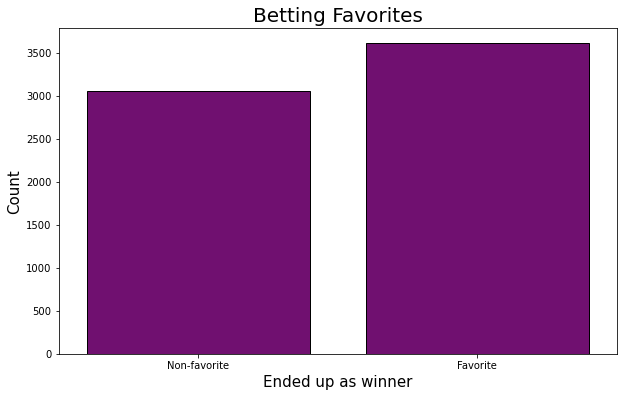

In [17]:
plt.figure(figsize=(10,6))
sns.countplot(x=df['Favorite_Winner'], color='purple', edgecolor='black')
plt.title('Betting Favorites', fontsize=20)
plt.xticks([0,1], ['Non-favorite','Favorite'])
plt.ylabel('Count', fontsize=15)
plt.xlabel('Ended up as winner',fontsize=15)
plt.show()

In [18]:
# percentage of betting favorites that ended up winning
print(len(df[df['Favorite_Winner']==1]) / len(df['Favorite_Winner']))

0.5421360973411447


How many times were the home team favored to win the match?

Text(0, 0.5, 'Count')

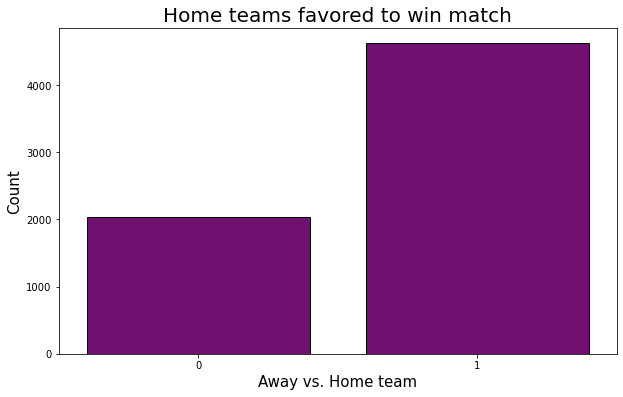

In [19]:
# count of home teams that were favored to win
plt.figure(figsize=(10,6))
sns.countplot(x=df['HomeTeam_Favorite'], color='purple', edgecolor='black')
plt.title('Home teams favored to win match', fontsize=20)
plt.xlabel('Away vs. Home team', fontsize=15)
plt.ylabel('Count', fontsize=15)

In [20]:
# percentage of games where the home team was the favorite
home_favorite_percentage = len(df[df['HomeTeam_Favorite'] == 1]) / len(df['HomeTeam_Favorite'])

print('Home Teams were favored in ' + str(round(home_favorite_percentage, ndigits=4)) + 
      '% of all matches in the dataset.')

Home Teams were favored in 0.6948% of all matches in the dataset.


In [21]:
# percentage of games where the home team was the favorite
away_favorite_percentage = len(df[df['HomeTeam_Favorite'] == 0]) / len(df['HomeTeam_Favorite'])

print('Away Teams were favored in ' + str(round(away_favorite_percentage, ndigits=4)) + 
      '% of all matches in the dataset.')

Away Teams were favored in 0.3052% of all matches in the dataset.


How many times did the home team that were betting favorites actually win?

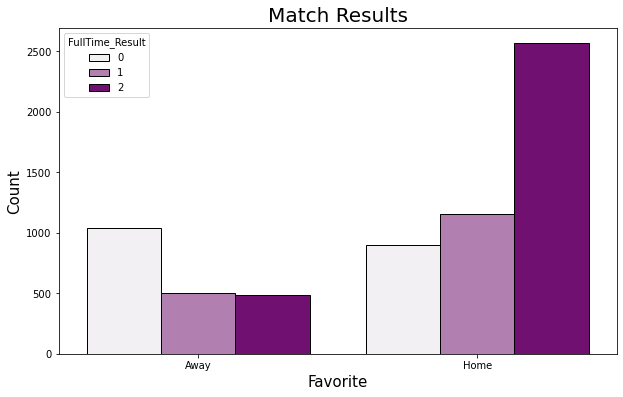

In [22]:
# count of home favorites that actually won
plt.figure(figsize=(10,6))
sns.countplot(x=df['HomeTeam_Favorite'], hue=df['FullTime_Result'], color='purple', edgecolor='black')
plt.xticks([0,1], ['Away','Home'])
plt.xlabel('Favorite', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Match Results', fontsize=20)
plt.show()

What was the general distribution of Full-Time match results in the dataset?

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


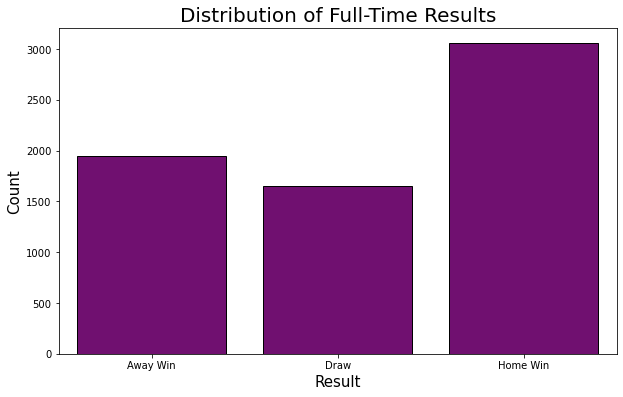

In [23]:
# Distribution of results
plt.figure(figsize=(10,6))
sns.countplot(df['FullTime_Result'], color='purple', edgecolor='black')
plt.xticks([0,1,2], ['Away Win','Draw','Home Win'])
plt.title('Distribution of Full-Time Results', fontsize=20)
plt.xlabel('Result', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

Did the teams that were winning at half-time go on to win the game at full-time?

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


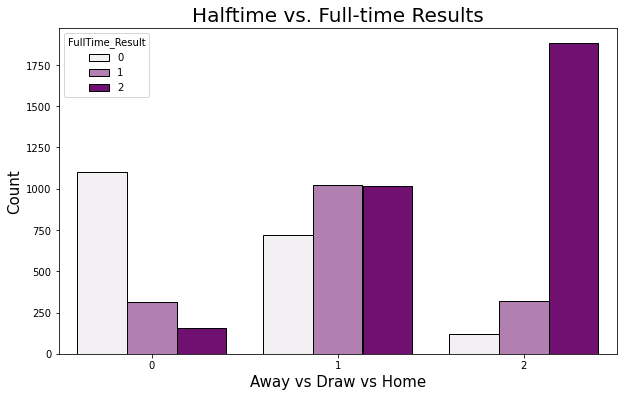

In [24]:
# how many teams leading at half time went on to win the game?
plt.figure(figsize=(10,6))
sns.countplot(df['HalfTime_Result'], hue=df['FullTime_Result'], color='purple', edgecolor='black')
plt.title('Halftime vs. Full-time Results', fontsize=20)
plt.xlabel('Away vs Draw vs Home', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

## Now that I've explored the data with visuals, time to move onto modeling...